In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
rho=1
u=[.1, 2.5]
gamma=.1

x_boundary=[0, 1]
nodes=5
dx=((x_boundary[1]-x_boundary[0])/nodes)

# Boundary conditions
phi_boundary=[1, 0]

x=np.arange(x_boundary[0] + dx/2, x_boundary[1], dx)
# For exact plot
x_exact_plot=np.arange(x_boundary[0] + dx/2, x_boundary[1], dx/19)

In [116]:
def quick(x, phi_boundary, x_boundary, rho, u, gamma):
    # Implementing Quick Scheme (Generalised)

    res=[]
    
    for u_now in u:
        # As we are considering equispaced points and uniform velocities throught the domain
        # F_e, F_w = F
        F=rho*u_now
        # D_e, D_w = D
        D=gamma/(x[1] - x[0])
        alpha = 1 if F>0 else 0
        
        A=np.zeros((x.shape[0], x.shape[0]))
        b=np.zeros((x.shape[0], 1))
        
        for i in range(x.shape[0]):
            if i == 0:
                #Using Central Differencing for creating mirror node wrt west boundary node
                a_p = 2*D+F/2
                a_e = D-F/2
                s_u = (D+F)*phi_boundary[0]
                
                A[i, i]   = a_p
                A[i, i+1] = -a_e
                b[i]      = s_u

            elif i == 1:
                # Node 1 (Near-Boundary)
                a_ww = 0
                a_w  = D + ((alpha+4)/8)*F
                a_e  = D + ((3*alpha-6)/8)*F
                a_ee = -(1-alpha)*F/ 8
                a_p  = a_w + a_e + a_ee + a_ww
                
                A[i, i-1] = -a_w
                A[i, i]   = a_p
                A[i, i+1] = -a_e
                A[i, i+2] = -a_ee
                b[i]      = -a_ww * phi_boundary[0]

            elif i == x.shape[0] - 2:
                # Node x.shape[0]-2 (Near-Boundary)
                a_ww = -alpha*F/8
                a_w  = D + ((9*alpha-3)/8)*F
                a_e  = D + ((5-9*alpha)/8)*F
                a_ee = -(1-alpha)*F/ 8
                a_p  = a_w + a_e + a_ww + a_ee
                
                A[i, i-2] = -a_ww
                A[i, i-1] = -a_w
                A[i, i]   = a_p
                A[i, i+1] = -a_e
                b[i]      = -a_ee * phi_boundary[1]
            
            elif i == x.shape[0] - 1:
                #Using Central Differencing for creating mirror node wrt east boundary node
                a_p = 2*D - F/2
                a_w = D + F/2
                s_u = (D-F) * phi_boundary[1]

                A[i, i-1] = -a_w
                A[i, i]   = a_p
                b[i]      = s_u

            else:
                a_ww = -alpha * F / 8
                a_w  = D + ((3+4*alpha)/8)*F
                a_e  = D + ((-7+4*alpha)/8)*F
                a_ee = (1-alpha)*F/ 8
                a_p  = a_w + a_e + a_ww + a_ee
                
                A[i, i-2] = -a_ww
                A[i, i-1] = -a_w
                A[i, i]   = a_p
                A[i, i+1] = -a_e
                A[i, i+2] = -a_ee

        dum=np.linalg.solve(A, b)
        res.append(dum)

    return res

In [117]:
def upwind(x, phi_boundary, x_boundary, rho, u, gamma):
    # Implementing upwind Scheme

    res=[]
    
    for u_now in u:
        # As we are considering equispaced points and uniform velocities throught the domain
        # F_e, F_w = F
        F=rho*u_now
        # D_e, D_w = D
        D=gamma/(x[1] - x[0])
        alpha = 1 if F>0 else 0
        
        # a_w  = D + max(F, 0)
        # a_e  = D + max(-F, 0)
        a_w  = D + F*alpha
        a_e  = D - F*(1-alpha)
        # F_w = F_e from equation of continuity
        a_p  = a_w + a_e + (F-F)

        A=np.zeros((x.shape[0], x.shape[0]))
        b=np.zeros((x.shape[0], 1))
        
        for i in range(x.shape[0]):
            A[i][i]=a_p
            if i-1>=0:
                A[i][i-1] = -a_w
            if i+1<x.shape[0]:
                A[i][i+1] = -a_e

            if i==0:
                A[i][i]    = 2*D + abs(F)
                A[i][i+1]  = -(D-(1-alpha)*F)
            if i==x.shape[0]-1:
                A[i][i-1]  = -(D+(alpha)*F)
                A[i][i]    = 2*D + abs(F)

        b[0][0]            = (D + alpha*F)    * phi_boundary[0]
        b[x.shape[0]-1][0] = (D -(1-alpha)*F) * phi_boundary[1]

        dum=np.linalg.solve(A, b)
        res.append(dum)

    return res

In [118]:
def exact(x, phi_boundary, x_boundary, rho, u, gamma):

    res=[]
    
    for u_now in u:
        a=rho*u_now/gamma
        # b=np.exp(a)-1
        
        # res.append((1/b)*(np.exp(a*(1-x))-1))
        d=(phi_boundary[1] - phi_boundary[0])/(np.exp(a*x_boundary[1]) - np.exp(a*x_boundary[0]))
        c= phi_boundary[1] - d*np.exp(a*x_boundary[1]) 

        res.append(d*np.exp(a*x) + c)
    
    return res

In [119]:
res_quick  = quick(x, phi_boundary, x_boundary, rho, u, gamma)
res_exact  = exact(x_exact_plot, phi_boundary, x_boundary, rho, u, gamma)
res_upwind = exact(x, phi_boundary, x_boundary, rho, u, gamma)

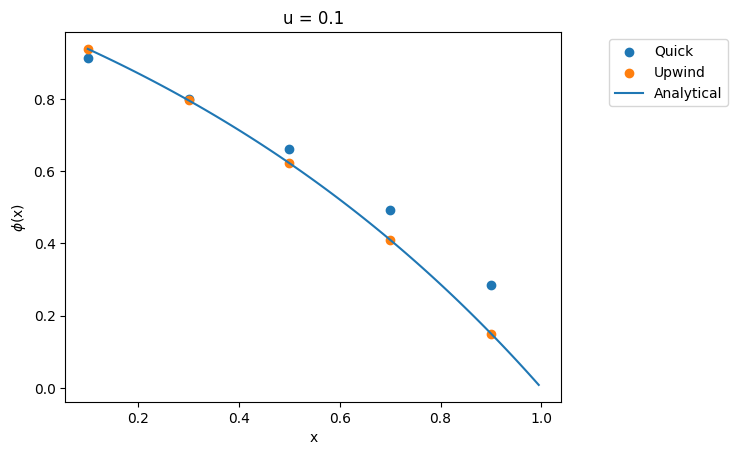

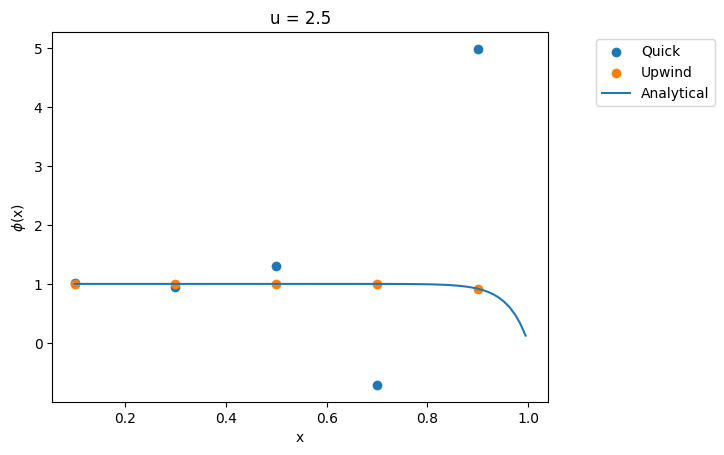

In [120]:
for i in range(len(u)):
    plt.scatter(x, res_quick[i])
    plt.scatter(x, res_upwind[i])
    plt.plot(x_exact_plot, res_exact[i])
    plt.title(f'u = {u[i]}')
    plt.xlabel('x')
    plt.ylabel(r'$\phi$(x)')
    plt.legend(['Quick', 'Upwind', 'Analytical'], bbox_to_anchor=(1.35, 1))
    plt.show()